In [283]:
import torch 
from torch import nn, Tensor

import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

In [284]:
class Flow(nn.Module):
    def __init__(self, dim: int = 2, h: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 1, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, dim))
    
    def forward(self, x_t: Tensor ,t: Tensor) -> Tensor:
        return self.net(torch.cat((t, x_t), -1))

# Training

In [285]:
flow = Flow()

optimizer = torch.optim.Adam(flow.parameters(), 1e-2)
loss_fn = nn.MSELoss()

for _ in range(10000):
    x_1 = Tensor(make_moons(256, noise=0.15)[0])
    x_0 = torch.randn_like(x_1)
    t = torch.rand(len(x_1), 1)
    
    x_t = (1 - t) * x_0 + t * x_1
    dx_t = x_1 - x_0
    
    optimizer.zero_grad()
    loss_fn(flow(t=t, x_t=x_t), dx_t).backward()
    optimizer.step()

# Sampling

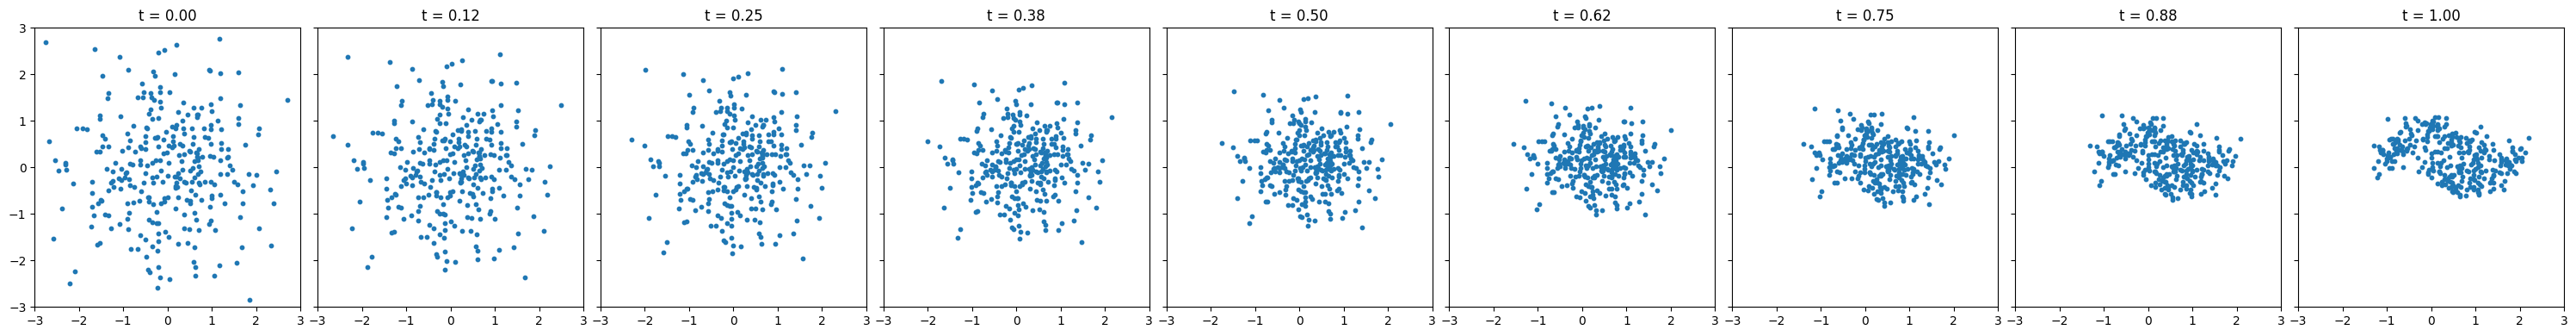

In [286]:
x = torch.randn(300, 2)
n_steps = 8
fig, axes = plt.subplots(1, n_steps + 1, figsize=(30, 4), sharex=True, sharey=True)
time_steps = torch.linspace(0, 1.0, n_steps + 1)

axes[0].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10)
axes[0].set_title(f't = {time_steps[0]:.2f}')
axes[0].set_xlim(-3.0, 3.0)
axes[0].set_ylim(-3.0, 3.0)


def step(self, x_t: Tensor, t_start: Tensor, t_end: Tensor) -> Tensor:
    t_start = t_start.view(1, 1).expand(x_t.shape[0], 1)
    return x_t + (t_end - t_start) * self(t=t_start, x_t=x_t)

for i in range(n_steps):
    x = step(self=flow,x_t=x, t_start=time_steps[i], t_end=time_steps[i + 1])
    axes[i + 1].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10)
    axes[i + 1].set_title(f't = {time_steps[i + 1]:.2f}')

plt.tight_layout()
plt.show()

In [287]:
from sklearn.datasets import make_moons
from torch.nn import Module
from torch import nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch import Tensor
import torch


class MoonsClassifier(Module):
    def __init__(self, dim: int = 2, h=64, n_labels=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, h),
            nn.ELU(),
            nn.Linear(h, h),
            nn.ELU(),
            nn.Linear(h, h),
            nn.ELU(),
            nn.Linear(h, n_labels),
        )

    def forward(self, x):
        logits = self.net(x)
        return logits


classifier_model = MoonsClassifier()
optimizer = AdamW(classifier_model.parameters())

for i in range(2000):
    x, c = make_moons(256, noise=0.15)
    x = Tensor(x)
    c = Tensor(c).long()
    logits = classifier_model(x)
    loss = F.cross_entropy(logits, c)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


x, c = make_moons(100, noise=0.15)
x = Tensor(x)
c = Tensor(c).long()
logits = classifier_model(x)
p_l = torch.argmax(logits, dim=-1)
print(p_l)
print(c)
acc = (p_l == c).float().sum() / 100
print(f"acc={acc}")


@torch.enable_grad()
def classifier_condition_loss(x: Tensor, c: Tensor, model: Module):
    c = c.squeeze(-1).long()
    logits = model(x)
    loss = F.cross_entropy(logits, c)
    return loss

tensor([1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
        1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,
        1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1,
        1, 1, 1, 1])
tensor([1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
        1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,
        1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1,
        1, 1, 1, 1])
acc=1.0


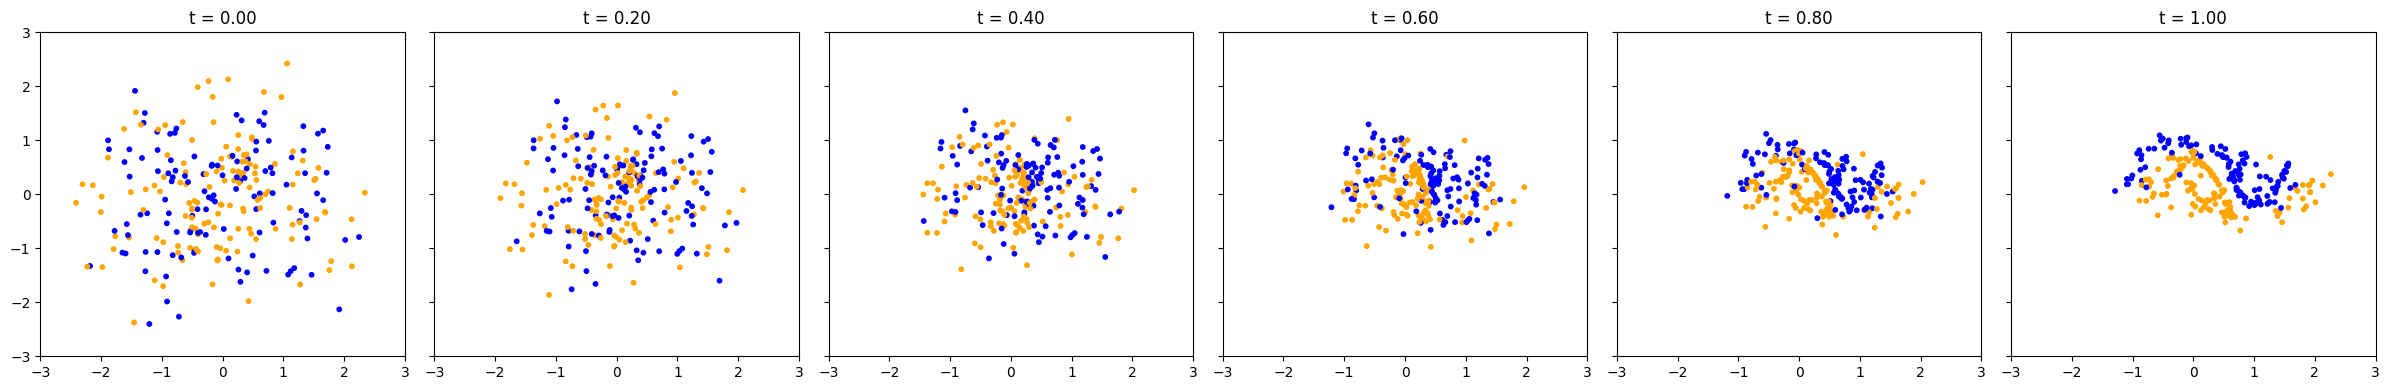

In [288]:
# --- evaluation / visualisation section --------------------------
n_samples = 256

sigma = 1.0
x = torch.randn(n_samples, 2) * sigma  # (n_samples, 2)

# if you just want random labels –– otherwise load real labels here
c_eval = torch.randint(0, 2, (n_samples, 1), dtype=torch.float32)  # (n_samples, 1)

# colours for the scatter (same length as x)
colors = ["blue" if lbl == 0 else "orange" for lbl in c_eval.squeeze().tolist()]

EPS = 1e-5


def get_posterior_mean_fn(vf=None, vf_fn=None):
    def _otfm_posterior_mean_fn(x_t, t):
        nonlocal vf, vf_fn
        assert vf is not None or vf_fn is not None, "Either vf or vf_fn must be provided"
        if vf is None:
            vf = vf_fn(x_t, t)
        x_1 = (1 - t) / (t + EPS) * (t * vf - x_t) + 1 / (t + EPS) * x_t
        return x_1

    return _otfm_posterior_mean_fn


def step(self, x_t: Tensor, t_start: Tensor, t_end: Tensor, c: Tensor) -> Tensor:
    t_start = t_start.view(1, 1).expand(x_t.shape[0], 1)
    p_dx_t = self(x_t=x_t, t=t_start)

    # posterior_mean_fn = get_posterior_mean_fn(vf=p_dx_t)
    with torch.enable_grad():
        # posterior_mean_fn = get_posterior_mean_fn(vf_fn=self)
        posterior_mean_fn = get_posterior_mean_fn(vf=p_dx_t)
        copied_x_t = x_t.detach().clone().requires_grad_()
        p_x_1 = posterior_mean_fn(x_t=copied_x_t, t=t_start)
        loss = classifier_condition_loss(p_x_1, c, classifier_model)
        grad = torch.autograd.grad(loss, copied_x_t)[0]
        cg_vf = -1.0 * grad
    p_vf = p_dx_t + 10.0 * cg_vf
    return x_t + (t_end - t_start) * p_vf


# -----------------------------------------------------------------
n_steps = 100
plot_every = 20
plot_indices = list(range(0, n_steps + 1, plot_every))
if plot_indices[-1] != n_steps:
    plot_indices.append(n_steps)

fig, axes = plt.subplots(1, len(plot_indices), figsize=(4 * len(plot_indices), 4), sharex=True, sharey=True)
time_steps = torch.linspace(0, 1.0, n_steps + 1)

# initial frame
axes[0].scatter(x[:, 0], x[:, 1], s=10, c=colors)
axes[0].set_title(f"t = {time_steps[0]:.2f}")
axes[0].set_xlim(-3.0, 3.0)
axes[0].set_ylim(-3.0, 3.0)

plot_count = 0
with torch.no_grad():  # no gradients while sampling
    for i in range(n_steps):
        x = step(self=flow, x_t=x, t_start=time_steps[i], t_end=time_steps[i + 1], c=c_eval)
        if (i + 1) in plot_indices:
            plot_count += 1
            axes[plot_count].scatter(x[:, 0], x[:, 1], s=10, c=colors)
            axes[plot_count].set_title(f"t = {time_steps[i + 1]:.2f}")
            axes[plot_count].set_xlim(-3.0, 3.0)
            axes[plot_count].set_ylim(-3.0, 3.0)

plt.tight_layout()
plt.show()

# Conditional Flow Matching
We now train a simple conditional model using class labels.

In [289]:
import torch 
from torch import nn, Tensor

import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

In [290]:
class Flow(nn.Module):
    def __init__(self, dim: int = 2, h: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 2, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, dim))
    
    def forward(self, t: Tensor, c: Tensor, x_t: Tensor ) -> Tensor:
        return self.net(torch.cat((t, c, x_t), -1))
    
    def step(self, x_t: Tensor, t_start: Tensor, t_end: Tensor, c: Tensor) -> Tensor:
        t_start = t_start.view(1, 1).expand(x_t.shape[0], 1)
        
        return x_t + (t_end - t_start) * self(t=t_start + (t_end - t_start) / 2, c = c, x_t= x_t + self(c = c, x_t=x_t, t=t_start) * (t_end - t_start) / 2)

# Training

In [291]:
flow = Flow()

optimizer = torch.optim.Adam(flow.parameters(), 1e-2)
loss_fn = nn.MSELoss()

for _ in range(10000):
    x_1, c = make_moons(256, noise=0.15)
    x_1 = Tensor(x_1)
    c = Tensor(c)
    c = c.view(-1, 1)
    
    x_0 = torch.randn_like(x_1)
    t = torch.rand(len(x_1), 1)
    
    x_t = (1 - t) * x_0 + t * x_1
    dx_t = x_1 - x_0
    
    optimizer.zero_grad()
    loss_fn(flow(t=t, x_t=x_t, c=c), dx_t).backward()
    optimizer.step()

# Sampling

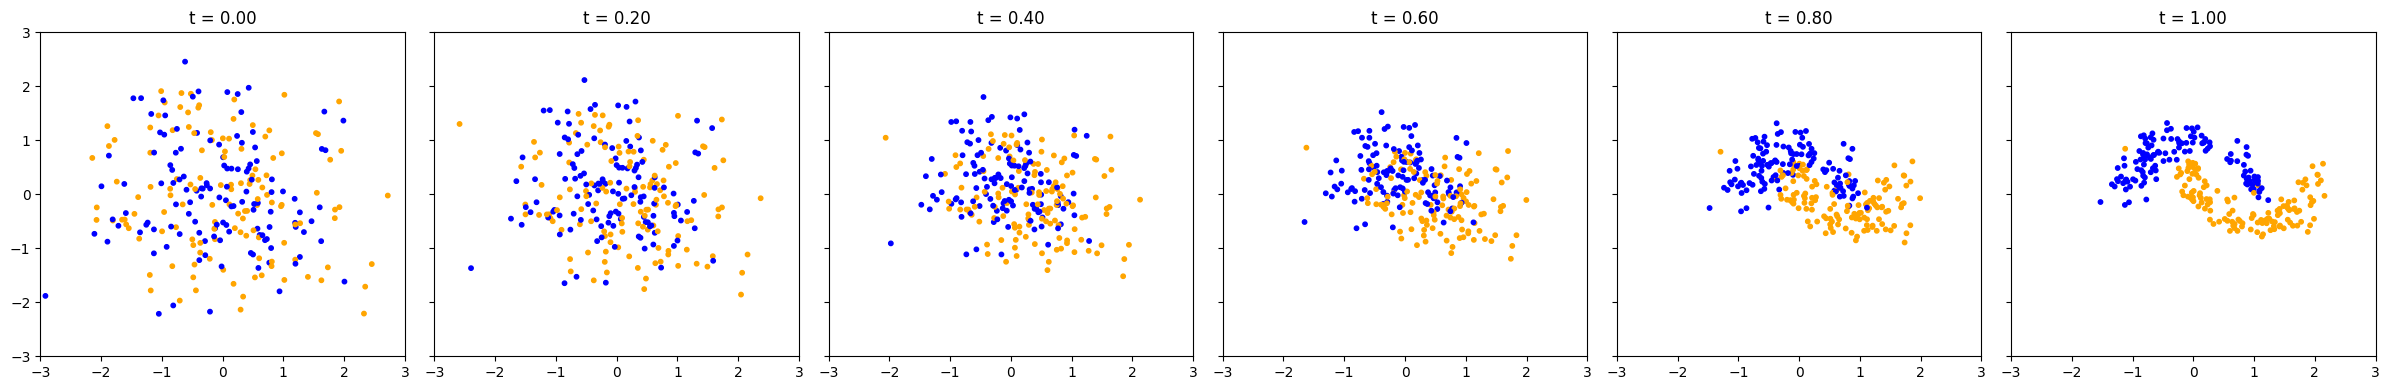

In [292]:
# --- evaluation / visualisation section --------------------------
n_samples = 256                    

sigma = 1.0
x      = torch.randn(n_samples, 2) * sigma     # (n_samples, 2)

# if you just want random labels –– otherwise load real labels here
c_eval = torch.randint(0, 2, (n_samples, 1), dtype=torch.float32)  # (n_samples, 1)

# colours for the scatter (same length as x)
colors  = ['blue' if lbl == 0 else 'orange' for lbl in c_eval.squeeze().tolist()]

# -----------------------------------------------------------------
n_steps      = 100
plot_every   = 20
plot_indices = list(range(0, n_steps + 1, plot_every))
if plot_indices[-1] != n_steps:
    plot_indices.append(n_steps)

fig, axes   = plt.subplots(1, len(plot_indices), figsize=(4 * len(plot_indices), 4),
                           sharex=True, sharey=True)
time_steps  = torch.linspace(0, 1.0, n_steps + 1)

# initial frame
axes[0].scatter(x[:, 0], x[:, 1], s=10, c=colors)
axes[0].set_title(f't = {time_steps[0]:.2f}')
axes[0].set_xlim(-3.0, 3.0)
axes[0].set_ylim(-3.0, 3.0)

plot_count = 0
with torch.no_grad():                         # no gradients while sampling
    for i in range(n_steps):
        x = flow.step(x_t=x,
                      t_start=time_steps[i],
                      t_end=time_steps[i + 1],
                      c=c_eval)               # 2️⃣ use the same‑sized label tensor
        if (i + 1) in plot_indices:
            plot_count += 1
            axes[plot_count].scatter(x[:, 0], x[:, 1], s=10, c=colors)
            axes[plot_count].set_title(f't = {time_steps[i + 1]:.2f}')
            axes[plot_count].set_xlim(-3.0, 3.0)
            axes[plot_count].set_ylim(-3.0, 3.0)

plt.tight_layout()
plt.show()
